In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def ex_potential(I_ex, x_step):
    # Parameters
    h = 10e-6
    rho_m = 1
    x_c = 150e-6
    x_ac = np.abs(x_step - x_c)
    
    # Check if I_ex is 1D or 2D
    if len(I_ex.shape) == 1:
        I_ex = I_ex[:, np.newaxis]  # Add a new axis to make it 2D
    
    # Calculate exterior potential
    V_ex = (I_ex * rho_m) / (4 * np.pi * np.sqrt(h**2 + x_ac**2))
    
    return V_ex


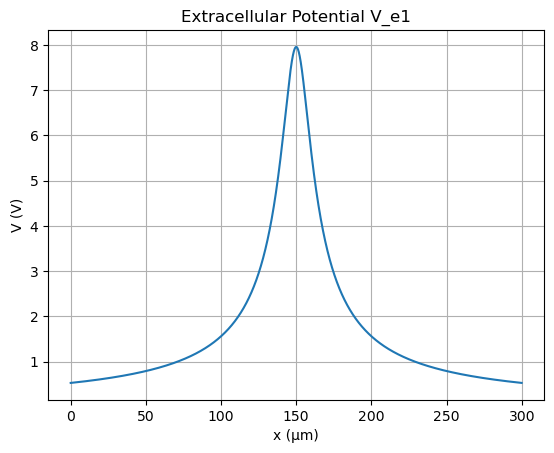

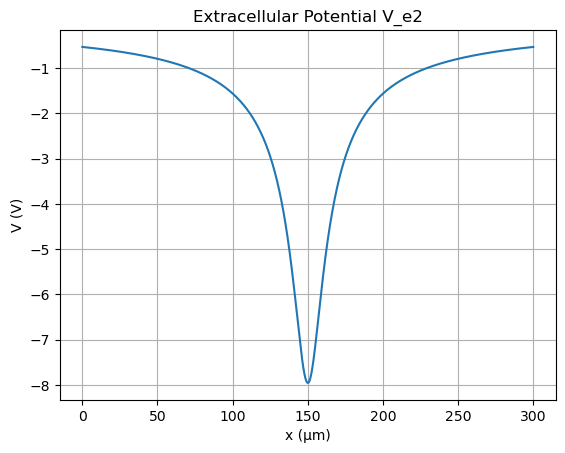

In [3]:
# Define parameters
x = np.arange(0, 300e-6, 0.1e-6)
h = 10e-6
rho_m = 1
I1 = 1e-3
I2 = -1e-3
x_c = 150e-6
x_ac = np.abs(x - x_c)

# Extracellular potential
V_e1 = (I1 * rho_m) / (4 * np.pi * np.sqrt(h**2 + x_ac**2))
V_e2 = (I2 * rho_m) / (4 * np.pi * np.sqrt(h**2 + x_ac**2))

# Plot V_e1
plt.figure()
plt.plot(x * 1e6, V_e1)
plt.xlabel("x (\u03bcm)")
plt.ylabel("V (V)")
plt.grid()
plt.title("Extracellular Potential V_e1")
plt.savefig('V_e1.png', format='png')
# plt.show()

# Plot V_e2
plt.figure()
plt.plot(x * 1e6, V_e2)
plt.xlabel("x (\u03bcm)")
plt.ylabel("V (V)")
plt.grid()
plt.title("Extracellular Potential V_e2")
plt.savefig('V_e2.png', format='png')
# plt.show()

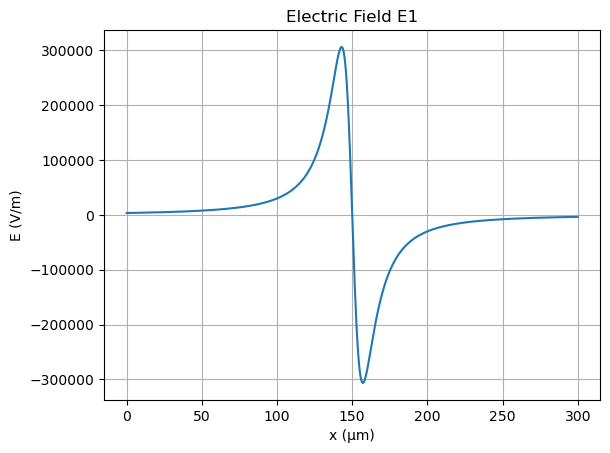

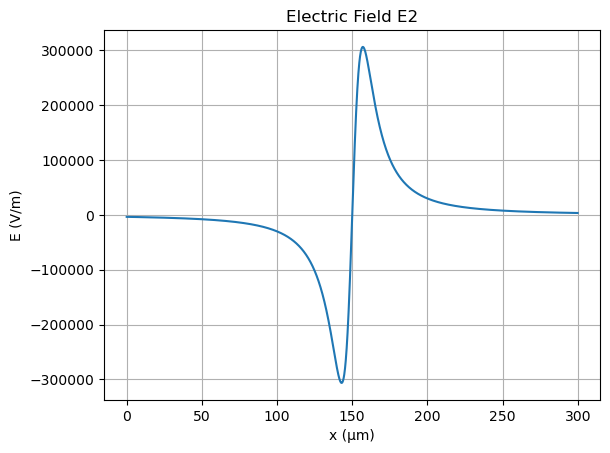

In [4]:
# Electric field
E1 = np.gradient(V_e1) / np.gradient(x)
E2 = np.gradient(V_e2) / np.gradient(x)

# Plot E1
plt.figure()
plt.plot(x * 1e6, E1)
plt.xlabel("x (\u03bcm)")
plt.ylabel("E (V/m)")
plt.grid()
plt.title("Electric Field E1")
plt.savefig('E1.png', format='png')
# plt.show()

# Plot E2
plt.figure()
plt.plot(x * 1e6, E2)
plt.xlabel("x (\u03bcm)")
plt.ylabel("E (V/m)")
plt.grid()
plt.title("Electric Field E2")
plt.savefig('E2.png', format='png')
# plt.show()


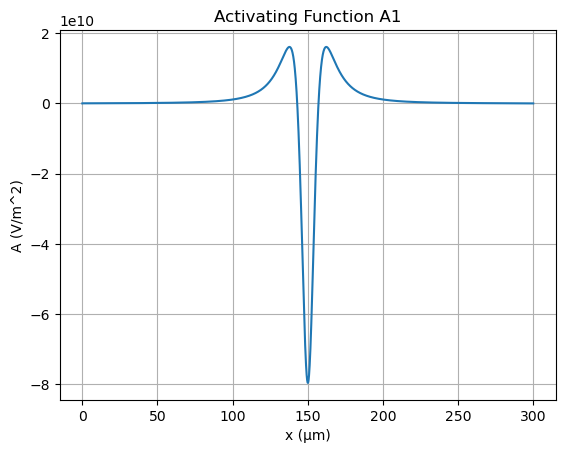

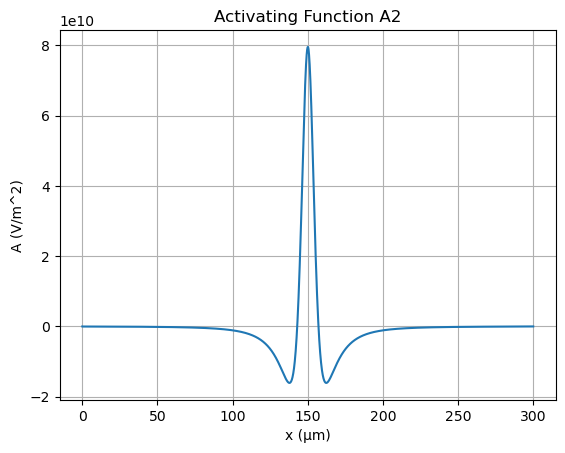

In [5]:
# Activating function
A1 = np.gradient(E1) / np.gradient(x)
A2 = np.gradient(E2) / np.gradient(x)

# Plot A1
plt.figure()
plt.plot(x * 1e6, A1)
plt.xlabel("x (\u03bcm)")
plt.ylabel("A (V/m^2)")
plt.grid()
plt.title("Activating Function A1")
plt.savefig('A1.png', format='png')
# plt.show()

# Plot A2
plt.figure()
plt.plot(x * 1e6, A2)
plt.xlabel("x (\u03bcm)")
plt.ylabel("A (V/m^2)")
plt.grid()
plt.title("Activating Function A2")
plt.savefig('A2.png', format='png')
# plt.show()

In [6]:
def hh_gating_6(V, dt, curr_gate, T):
    # Number of points
    num_points = 100
    
    # Initialize arrays
    alpha = np.zeros((num_points, 3))
    beta = np.zeros((num_points, 3))
    
    # Calculate alpha and beta rate equations
    alpha[:, 0] = 1e3 * ((2.5 - 100 * V) / (np.exp(2.5 - 100 * V) - 1))
    beta[:, 0] = 4e3 * np.exp(-500 * V / 9)

    alpha[:, 1] = 1000 * ((0.1 - 10 * V) / (np.exp(1 - 100 * V) - 1))
    beta[:, 1] = 125 * np.exp(-25 * V / 2)

    alpha[:, 2] = 70 * np.exp(-50 * V)
    beta[:, 2] = 1000 / (np.exp(3 - 100 * V) + 1)
    
    # Temperature correction
    k = 3**(0.1 * (T - 6.3))
    
    # A and B coefficients for exponential solver
    A = -k * (alpha + beta)
    B = k * alpha
    
    # Calculate gating variables m, n, h for the future timestep using the exponential euler solver
    array_g = np.zeros((num_points, 3))
    
    array_g[:, 0] = curr_gate[:, 0] * np.exp(A[:, 0] * dt) + (B[:, 0] / A[:, 0]) * (np.exp(A[:, 0] * dt) - 1)
    array_g[:, 1] = curr_gate[:, 1] * np.exp(A[:, 1] * dt) + (B[:, 1] / A[:, 1]) * (np.exp(A[:, 1] * dt) - 1)
    array_g[:, 2] = curr_gate[:, 2] * np.exp(A[:, 2] * dt) + (B[:, 2] / A[:, 2]) * (np.exp(A[:, 2] * dt) - 1)
    
    # Assign output
    new_gate = array_g
    
    return new_gate

In [7]:
def hh_potential_6(V, dt, I_ions, V_ex):
    # Parameters
    C_m = 1e-6
    rho_ax = 7e-3
    r_ax = 1e-6
    l_comp = 3e-6
    R_a = (rho_ax * l_comp) / (np.pi * r_ax**2)
    
    # Matrices
    vec = np.ones(100)
    d_0 = -2 * vec
    vec = np.ones(99)
    
    diag_0 = np.diag(d_0, 0)
    diag_m1 = np.diag(vec, -1)
    diag_1 = np.diag(vec, 1)
    
    C = diag_m1 + diag_0 + diag_1
    C[0, 0] = -1
    C[-1, -1] = -1
    
    I = np.eye(100)
    
    # Add up the currents
    I_HH = I_ions[:, 0] + I_ions[:, 1] + I_ions[:, 2]
    
    # Obtain the parameters for the equation system
    A = I - ((dt / (C_m * R_a)) * C)
    b = V + ((dt / C_m) * (-I_HH)) + ((dt / (C_m * R_a)) * C @ V_ex)
    
    # Solve the system of linear equations
    V_new = np.linalg.solve(A, b)
    
    return V_new

In [8]:
def hh_model_6(I_ex, t_end, dt, T):
    # Definitions and constants
    m = np.arange(1, 101)
    l_comp = 3e-6
    x_step = l_comp * m

    Vrest = 0e-3
    t = np.arange(0, t_end, dt)

    V_Na = 115e-3
    V_K = -12e-3
    V_L = 10.6e-3

    g_Na = 120e-3
    g_K = 36e-3
    g_L = 0.3e-3

    alpha_m = lambda V: 1000 * ((2.5 - 100 * V) / (np.exp(2.5 - 100 * V) - 1))
    beta_m = lambda V: 4000 * np.exp(-500 * V / 9)

    alpha_n = lambda V: 1000 * ((0.1 - 10 * V) / (np.exp(1 - 100 * V) - 1))
    beta_n = lambda V: 125 * np.exp(-25 * V / 2)

    alpha_h = lambda V: 70 * np.exp(-50 * V)
    beta_h = lambda V: 1000 / (np.exp(3 - 100 * V) + 1)

    alpha_0 = np.zeros((len(m), 3))
    beta_0 = np.zeros((len(m), 3))

    V = np.zeros((len(m), len(t)))
    gates = np.zeros((len(m), 3, len(t)))
    I_ions = np.zeros((len(m), 3, len(t)))

    # Exterior potential vector
    V_ex = np.zeros((len(m), len(t)))

    # Initial calculations
    for j in range(len(m)):
        V[j, 0] = Vrest

        alpha_0[j, 0] = alpha_m(V[0, 0])
        alpha_0[j, 1] = alpha_n(V[0, 0])
        alpha_0[j, 2] = alpha_h(V[0, 0])

        beta_0[j, 0] = beta_m(V[0, 0])
        beta_0[j, 1] = beta_n(V[0, 0])
        beta_0[j, 2] = beta_h(V[0, 0])

        for i in range(3):
            gates[j, i, 0] = alpha_0[j, i] / (alpha_0[j, i] + beta_0[j, i])

    # Iterative calculation of the membrane potential
    for i in range(len(t) - 1):
        gates[:, :, i + 1] = hh_gating_6(V[:, i], dt, gates[:, :, i], T)
        
        I_ions[:, 0, i + 1] = g_Na * (gates[:, 0, i + 1] ** 3) * gates[:, 2, i + 1] * (V[:, i] - V_Na)
        I_ions[:, 1, i + 1] = g_K * (gates[:, 1, i + 1] ** 4) * (V[:, i] - V_K)
        I_ions[:, 2, i + 1] = g_L * (V[:, i] - V_L)

        # Calculate the exterior potential for the future timestep
        V_ex[:, i + 1] = ex_potential(I_ex[i + 1], x_step)
        
        # Calculate membrane potential of a future timestep and current compartment
        V[:, i + 1] = hh_potential_6(V[:, i], dt, I_ions[:, :, i + 1], V_ex[:, i + 1])

    return V, gates, I_ions, t


In [9]:

# Define parameters
t_end = 30e-3  # Simulation duration in s
dt = 25e-6  # Time step in s
T = 6.3  # Simulation temperature in °C

x = np.arange(0, 300e-6, 0.1e-6)
h = 10e-6
rho_m = 1
x_c = 150e-6
x_ac = np.abs(x - x_c)

m = np.arange(1, 101)

# Create outside stimulation
t0 = np.arange(0, t_end, dt)
td = np.arange(0, 1e-3, dt)
ti = np.arange(5e-3, t_end, dt)

mp_t = np.concatenate([np.zeros(len(t0) - len(ti)), np.ones(len(td)), np.zeros(len(ti) - len(td))])
bp_2_t = np.concatenate([np.zeros(len(t0) - len(ti)), np.zeros(len(td)), np.ones(len(td)), np.zeros(len(ti) - 2 * len(td))])

I = [-0.05e-3, -0.1e-3, -0.1e-3, 0.1e-3, -0.15e-3, 0.15e-3, 0.2e-3, 0.4e-3]

I_ex1 = mp_t * I[0]
I_ex2 = mp_t * I[1]
I_ex3 = mp_t * I[2] + bp_2_t * I[3]
I_ex4 = mp_t * I[4] + bp_2_t * I[5]
I_ex5 = mp_t * I[6]
I_ex6 = mp_t * I[7]

# Run the hh_model function
V1, gates1, I_ions1, t = hh_model_6(I_ex1, t_end, dt, T)
V2, gates2, I_ions2, t2 = hh_model_6(I_ex2, t_end, dt, T)
V3, gates3, I_ions3, t3 = hh_model_6(I_ex3, t_end, dt, T)
V4, gates4, I_ions4, t4 = hh_model_6(I_ex4, t_end, dt, T)
V5, gates5, I_ions5, t5 = hh_model_6(I_ex5, t_end, dt, T)
V6, gates6, I_ions6, t6 = hh_model_6(I_ex6, t_end, dt, T)

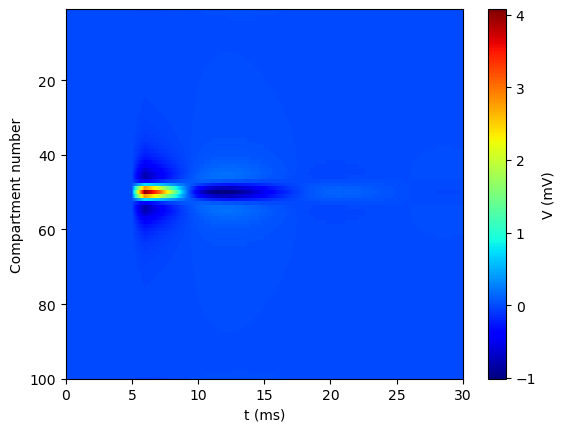

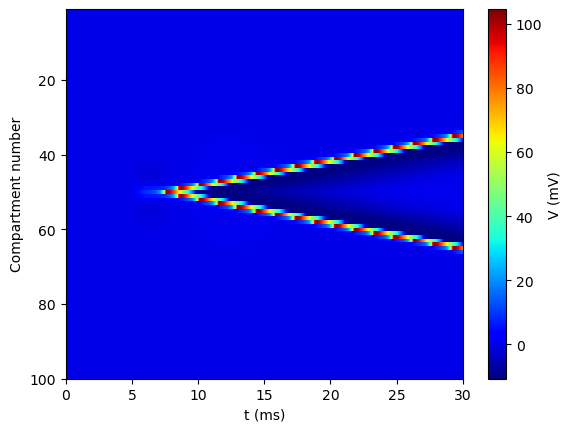

In [10]:
fig, ax = plt.subplots()
im = ax.pcolormesh(t * 1e3, m, V1 * 1e3, cmap='jet')
ax.set_ylim(100, 1)  # Reverse the y-axis
ax.set_xlim(0, 30)
ax.set_xlabel("t (ms)")
ax.set_ylabel("Compartment number")
fig.colorbar(im, label="V (mV)")
plt.savefig('Negative Mono-phasic current pulse(I=-0.05 mA).png', format='png')

fig, ax = plt.subplots()
im = ax.pcolormesh(t * 1e3, m, V2 * 1e3, cmap='jet')
ax.set_ylim(100, 1)  # Reverse the y-axis
ax.set_xlim(0, 30)
ax.set_xlabel("t (ms)")
ax.set_ylabel("Compartment number")
fig.colorbar(im, label="V (mV)")
plt.savefig('Negative Mono-phasic current pulse(I=-0.1 mA).png', format='png')

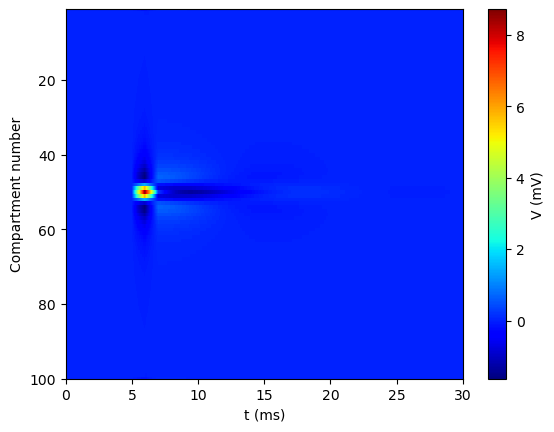

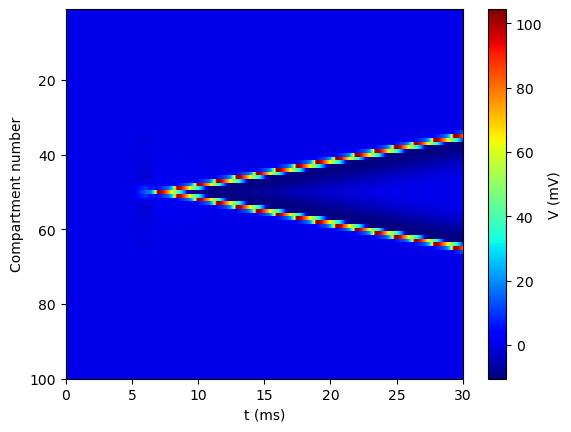

In [11]:
fig, ax = plt.subplots()
im = ax.pcolormesh(t * 1e3, m, V3 * 1e3, cmap='jet')
ax.set_ylim(100, 1)  # Reverse the y-axis
ax.set_xlim(0, 30)
ax.set_xlabel("t (ms)")
ax.set_ylabel("Compartment number")
fig.colorbar(im, label="V (mV)")
plt.savefig('Bi-phasic current pulse (I = -+0.1 mA).png', format='png')

fig, ax = plt.subplots()
im = ax.pcolormesh(t * 1e3, m, V4 * 1e3, cmap='jet')
ax.set_ylim(100, 1)  # Reverse the y-axis
ax.set_xlim(0, 30)
ax.set_xlabel("t (ms)")
ax.set_ylabel("Compartment number")
fig.colorbar(im, label="V (mV)")
plt.savefig('Bi-phasic current pulse (I = -+0.15 mA).png', format='png')

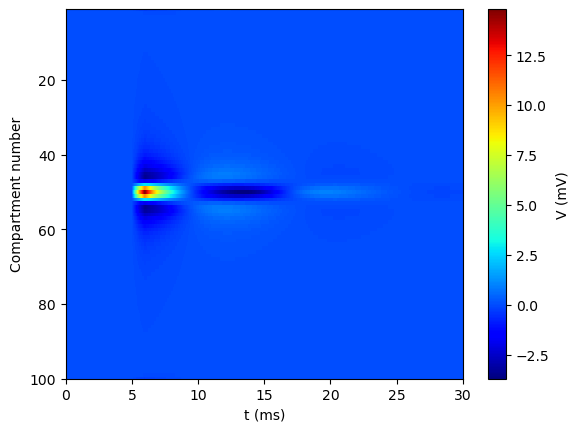

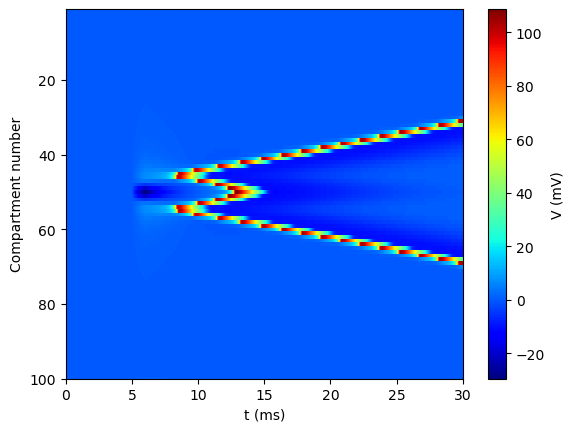

In [12]:
fig, ax = plt.subplots()
im = ax.pcolormesh(t * 1e3, m, -V5 * 1e3, cmap='jet')
ax.set_ylim(100, 1)  # Reverse the y-axis
ax.set_xlim(0, 30)
ax.set_xlabel("t (ms)")
ax.set_ylabel("Compartment number")
fig.colorbar(im, label="V (mV)")
plt.savefig('Positive Mono-phasic current pulse(I=0.2 mA).png', format='png')

fig, ax = plt.subplots()
im = ax.pcolormesh(t * 1e3, m, V6 * 1e3, cmap='jet')
ax.set_ylim(100, 1)  # Reverse the y-axis
ax.set_xlim(0, 30)
ax.set_xlabel("t (ms)")
ax.set_ylabel("Compartment number")
fig.colorbar(im, label="V (mV)")
plt.savefig('Positive Mono-phasic current pulse(I=0.4 mA).png', format='png')

